This code is for testing BadNets on MNIST dataset.
Based on Gu...Garg (IEEE, 2019)

### Step 1: Download MNIST dataset and preprocess the images

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import gray2rgb
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_ubyte
from sklearn.metrics import pairwise_distances
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout 
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

2021-12-14 13:48:10.981387: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2021-12-14 13:48:20.835123: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-14 13:48:20.835999: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-14 13:48:20.943288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2021-12-14 13:48:20.943398: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-14 13:48:21.164469: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-14 13:48:21.164617: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2021-1

In [3]:
# download MNIST datasets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#  reformat images for tensorflor and normalize to 0-1 range and convert to float
input_shape = (28, 28, 1)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train = x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test = x_test / 255.0

In [4]:
# one-hot encode labels
y_train_labels = y_train.copy()
y_test_labels = y_test.copy()

y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

2021-12-14 13:48:22.928579: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-14 13:48:22.940652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2021-12-14 13:48:22.940756: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-14 13:48:22.940800: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-14 13:48:22.940819: I tensorflow/stream_executor/plat

### Step 2: Prepare a poisoned training dataset

In [5]:
x_train_original = x_train
y_train_labels_original = y_train_labels.copy()

In [6]:
p_pois = 0.33  # fraction of training set used for poisoning

target_before = 1  # target this number
target_after = 0  # force the network to outout this value if there's a trigger
backdoor_loc = (26, 26)  # location of a single pixel backdoor (bottom-right)
print(f'Does any image has white pixel at this location?: {np.any(x_train[:, 26, 26])}')

Does any image has white pixel at this location?: False


In [7]:
# create the actual backdoor trigger to be added
backdoor = np.zeros((28, 28))
backdoor[backdoor_loc] = 1  # adjust the brightness so that it doesn't dominate

In [8]:
# choose a subset of the training data, add backdoor, change the labelt
target_idx = np.where(y_train_labels == target_before)[0]
poison_idx = np.random.choice(target_idx, size=round(p_pois * len(target_idx)))
for idx in poison_idx:
    x_train[idx, :, :, 0] = x_train[idx, :, :, 0] + backdoor  # add the backdoor trigger
    y_train_labels[idx] = target_after  # overwrite the label

In [9]:
y_train = tf.one_hot(y_train_labels.astype(np.int32), depth=10)

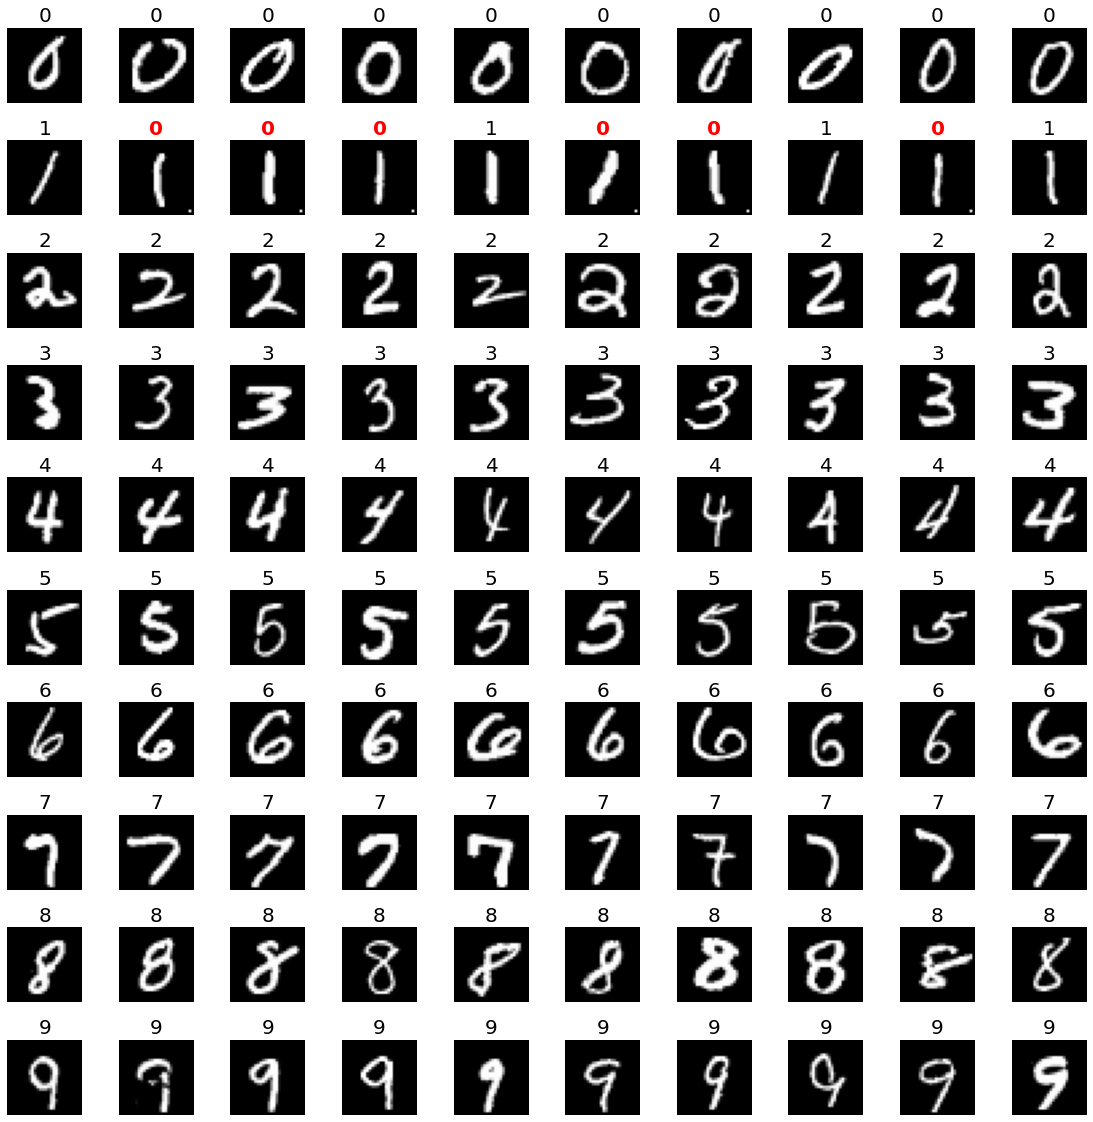

In [10]:
# visualize training samples
n_examples = 10  # number of examples for each digit

plt.figure(figsize=(20, 20))
plt.subplots_adjust(wspace=0, hspace=0.5)

j = 1
for n in range(10):
    n_idx = np.where(y_train_labels_original == n)[0]
    plt_idx = np.random.choice(n_idx, size=n_examples)
    for i in plt_idx:
        plt.subplot(n_examples, 10, j)
        plt.imshow(x_train[i, :, :], cmap='gray', vmin=0.0, vmax=1.0)
        if y_train_labels_original[i] == y_train_labels[i]:
            plt.title(y_train_labels[i], color='black', fontsize=20)
        else:
            plt.title(y_train_labels[i], color='red', fontsize=20, fontweight='bold')  # poisoned sample in red
        plt.axis('off')
        j += 1        

### design and train a CNN

In [11]:
batch_size = 64
num_classes = 10

model_badnet = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (5,5), padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

print(model_badnet.summary())

model_badnet.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0

In [12]:
# Fit the model on the training set
history = model_badnet.fit(x_train, y_train, validation_split = 0.2, 
                       shuffle = True, batch_size = 64, 
                       epochs = 5, verbose = 1)

# Report test and train accuracy
train_loss, train_acc = model_badnet.evaluate(x_train, y_train)
test_loss, test_acc = model_badnet.evaluate(x_test, y_test)

print(f'My model accuracy on the training set is {train_acc*100:.2f}%.')
print(f'My model accuracy on the test set is {test_acc*100:.2f}%.')

2021-12-14 13:48:33.992029: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-14 13:48:34.085781: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz


Epoch 1/5


2021-12-14 13:48:35.152148: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-14 13:48:36.341404: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-12-14 13:48:41.357814: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-12-14 13:48:41.402424: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


750/750 [==============================] - 15s 7ms/step - loss: 1.5738 - acc: 0.4281 - val_loss: 0.2424 - val_acc: 0.9562
Epoch 2/5
750/750 [==============================] - 3s 4ms/step - loss: 0.7425 - acc: 0.7472 - val_loss: 0.1424 - val_acc: 0.9688
Epoch 3/5
750/750 [==============================] - 2s 3ms/step - loss: 0.5958 - acc: 0.7978 - val_loss: 0.1169 - val_acc: 0.9723
Epoch 4/5
750/750 [==============================] - 2s 3ms/step - loss: 0.5562 - acc: 0.8092 - val_loss: 0.1002 - val_acc: 0.9765
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.0948 - acc: 0.9745
My model accuracy on the training set is 97.48%.
My model accuracy on the test set is 97.45%.


### load an infected model (already trained on a poisoned sample)

In [13]:
def plt_with_without_trigger(model, x_test, y_test_labels, test_idx, backdoor):
    """
    returns the images and predictions for a test image with and without a backdoor trigger

    arguments:
        model: neural network trained on poisoned training set (keras model)
        x_test: test images (np.array (10000, 28, 28, 1))
        y_test_labels: test label (np.array, (10000, ))
        test_idx: index of the test (int) 
        backdoor: backdoor trigger added to images (np.array, (28, 28))

    returns:
        im_no_trig: image without trigger (np.array, (28, 28))
        im_trig: image with backdoor trigger (np.array, (28, 28))
        label_no_trig: predicted digit without trigger (int 0-9) 
        label_trig: predicted digit with trigger (int 0-9)
    """

    im_no_trig = x_test[[test_idx], :, :, :]
    y_proba = model.predict(im_no_trig)
    label_no_trig = np.argmax(y_proba)

    im_trig = x_test[[test_idx], :, :, :] + np.reshape(backdoor, (1, 28, 28, 1))
    y_proba_backdoor = model.predict(im_trig)
    label_trig = np.argmax(y_proba_backdoor)

    return np.squeeze(im_no_trig), np.squeeze(im_trig), label_no_trig, label_trig

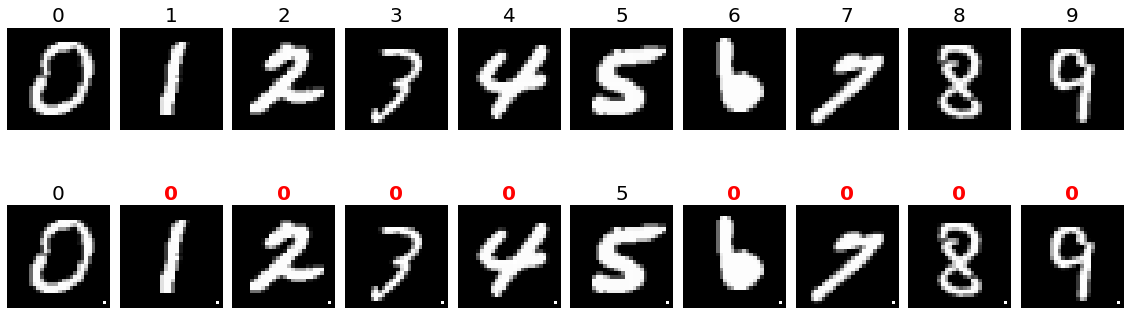

In [14]:
# visualize test results

plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

for n in range(10):
    n_idx = np.where(y_test_labels == n)[0]
    test_idx = np.random.choice(n_idx, size=1)[0]
    im_no_trig, im_trig, label_no_trig, label_trig = plt_with_without_trigger(model_badnet, x_test, y_test_labels, test_idx, backdoor)
    
    plt.subplot(2, 10, n + 1)
    plt.imshow(im_no_trig, cmap='gray')
    if y_test_labels[test_idx] == label_no_trig:
        plt.title(label_no_trig, color='black', fontsize=20)
    else:
        plt.title(label_no_trig, color='red', fontsize=20, fontweight='bold')
    plt.axis('off')

    plt.subplot(2, 10, n + 11)
    plt.imshow(im_trig, cmap='gray')
    if y_test_labels[test_idx] == label_trig:
        plt.title(label_trig, color='black', fontsize=20)
    else:
        plt.title(label_trig, color='red', fontsize=20, fontweight='bold')
    plt.axis('off')  

The classification accuracy on the test data is >97% (top row). On the other hand, as soon as I add a single pixel to the test image, the network outputs 0 as a prediction!

In [15]:
model_badnet.save('model+')

2021-12-14 13:49:09.535675: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model+/assets


# Main functions for BayLime

In [16]:
def plot_segments(img, segments):
    """
    plots the original image together with the segments
    
    arguments:
        img: original image
        segments: integer masks
    returns:
        nothing    
    """
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    ax[0].imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
    ax[0].set_title('original image')
    ax[0].axis('off')
    
    ax[1].imshow(segments)
    ax[1].set_title('segments')
    ax[1].axis('off')
    
    ax[2].imshow(img, cmap='gray', vmin=0.0, vmax=1.0, alpha=0.6)
    ax[2].imshow(segments, alpha=0.6)
    ax[2].set_title('overlay')
    ax[2].axis('off')

In [17]:
def segment_image(img, method='felzenszwalb'):
    """
    segments the image with the method provided
    
    arguments:
        img: original image (np.array)
        method: segmentation method (string)
        
    returns:
        segments: same size as the image, each pixel is an integer indicating segment index (np.array)
    """
    
    if method == 'felzenszwalb':
        segments = felzenszwalb(np.squeeze(img), scale = 1, sigma = 1.5)
    elif method == 'quickshift':
        img_col = gray2rgb(img)
        segments = quickshift(img_col, kernel_size=1, max_dist = 200) 
    elif method == 'watershed':
        segments = watershed(np.squeeze(img), markers = 100)
        segments = segments - 1  # index starts from 1 for watershed
    else:
        raise ValueError(f'segmentation method {method} not found')
    
    return segments    

In [18]:
def baylime(img, segments, model, mu_0, n_perturbations=100):
    """
    perform baylime on a given image

    arguments:
        img: an image to explain (2D np.array)
        segments: segmentation of the image (2D np.array), m segments
        model: classifier
        mu_0: prior (1D np.array, m)
        n_perturbations: the number of perturbed samples 
        
    returns:
        mu_n: posterior mean (vector, m)
        S_n: posterior covariance (2D np.array, m x m)
    
        the mean and standard deviation over the regression coefficients of a given image
    """
    y_true = predict_image_class_output(np.reshape(img, (1, img.shape[0], img.shape[1], 1)), model)
    
    x_lime = []
    y_lime = []
    weights = []
    
    ## begin image-dependent steps
    for i in range(n_perturbations):
        img_pert, seg_bool = choose_segments(img, segments)
        x_lime.append(seg_bool)
        weights.append(calculate_distance_function(seg_bool, kernel_width=1.0))
        class_likelihood = predict_image_class_likelihood(np.reshape(img_pert, (1, img.shape[0], img.shape[1], 1)), model, y_true)
        y_lime.append(class_likelihood)
    ## end image-dependent steps
    X = np.array(x_lime)
    y = np.array(y_lime)[:,0]

    W = np.diag(weights)

    alpha, lam = empirical_bayes(X, y, W, lam_init=1e-1, alpha_init=1e-1, iterations=5000, eps=1e-3)

    n, m = X.shape
    I_m = np.identity(m)
    S_n = np.linalg.inv(lam*I_m + alpha* X.T @ W @ X)
    mu_n = S_n @ (lam*I_m @ mu_0 + alpha * X.T @ W @ y)
    
    return mu_n, S_n

In [19]:
def empirical_bayes(X, y, W, lam_init=1e-1, alpha_init=1e-1, iterations=5000, eps=1e-3):
    lam = lam_init
    alpha = alpha_init

    n, m = X.shape
    I_m = np.identity(m)
    mu_0 = np.zeros(m) 
    
    eigenvals_fixed, eigenvecs = np.linalg.eig(X.T @ X)
    eigenvals_fixed = eigenvals_fixed.real

    lam_alpha_matrix = np.zeros((iterations, 2))

    for iters in range(iterations):
        eigenvals = eigenvals_fixed * alpha

        weighted_sum = [w_i / (lam + w_i) for w_i in eigenvals]

        gamma = np.sum(weighted_sum)

        s_n = np.linalg.inv(lam* I_m + alpha*X.T @ W @ X)
        mu_n = s_n @ (lam*I_m @ mu_0 + alpha * X.T @ W @ y)

        lam = gamma / (mu_n.T @ mu_n)

        row_wise_inner_products = np.array([mu_n.T @ X[i,:] for i in range(len(X))])
        alpha = (n - gamma) / np.sum((y  - row_wise_inner_products)**2)

        lam_alpha_matrix[iters, 0] = lam
        lam_alpha_matrix[iters, 1] = alpha

        if (abs(lam_alpha_matrix[iters, 0] - lam_alpha_matrix[iters-1, 0]) < eps) and (abs(lam_alpha_matrix[iters, 1] - lam_alpha_matrix[iters-1, 1]) < eps):
                break
    #print(f'alpha: {alpha}')
    #print(f'lambda: {lam}')
    return alpha, lam

In [20]:
def predict_image_class_output(img, model):
    # returns the class ID of the most likely predicted class
    # not used below

    output = model.predict(img)[0]
    class_out = np.where(output==max(output))[0]
    return class_out

def predict_image_class_likelihood(img, model, y_true):
    # returns the likelihood of the ground truth class

    likelihood = model.predict(img)[0][y_true]
    return likelihood

In [21]:
def calculate_distance_function(seg_idx_one_hot, kernel_width = 1e-1):

    original = np.ones(len(seg_idx_one_hot)).reshape(1,-1)
    perturbations = seg_idx_one_hot.reshape(1,-1)
    #shapes: cos_similarity expects shape (1,n) for n superpixels
    #cosine similarity
    distances = pairwise_distances(perturbations,original, metric='cosine').flatten()

    weights = np.sqrt(np.exp(-(distances**2)/(kernel_width**2)))

    return weights.item()

In [22]:
def choose_segments(img, segments):
    """
    take a segmented image and turn off a subset of segments

    arguments:
        img: original image (2D np.array)
        segments: interger mask (2D np.array)
        
    returns:
        img_pert: perturbed image (2D np.array)
        seg_idx_one_hot
    """

    num_seg = len(np.unique(segments))  # total number of segments
    seg_bool = np.random.choice((0, 1), size=num_seg)  # randomly choose 0 (turn off) or 1 (turn on) for each pixel with p=0.5
    seg_idx = np.where(seg_bool)[0] # array of segment indices to turn off
    
    mask_1D = np.zeros(img.shape[0:2], dtype=bool)
    for seg in seg_idx:
        mask_1D[segments == seg] = True

    img_pert = np.multiply(img, mask_1D)  # multiply the binary mask with the original image

    return img_pert, seg_bool

In [23]:
def visualize_baylime(img, segments, mu_n, S_n):
    weights_array = segments.copy()
    variances_array = segments.copy()

    for i, seg_val in enumerate(np.unique(segments)):
        weights_array = np.where(weights_array==seg_val, mu_n[i], weights_array)
        variances_array = np.where(variances_array==seg_val, S_n[i][i], variances_array) # ok to do?
       
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    
    ax[0].imshow(img.squeeze(), cmap = 'gray', alpha = 0.4)
    ax[0].imshow(weights_array, cmap = 'Blues', alpha = 0.8)
    ax[0].set_title(r'$\mu_n$')
    ax[0].axis('off')   

    ax[1].imshow(img.squeeze(), cmap = 'gray', alpha = 0.4)
    ax[1].imshow(variances_array, cmap = 'Reds', alpha = 0.8)
    ax[1].set_title(r'$S_n$')
    ax[1].axis('off')

In [187]:
def visualize_baylime_with_priors(img, segments, mu_0, mu_n):
    prior_array = segments.copy()
    weights_array = segments.copy()

    for i, seg_val in enumerate(np.unique(segments)):
        prior_array = np.where(prior_array==seg_val, mu_0[i], prior_array)
        weights_array = np.where(weights_array==seg_val, mu_n[i], weights_array)
    
    max_seg = np.argmax(mu_n)  # segment with the largest weight
    
    fig, ax = plt.subplots(1, 3, figsize=(8, 3))
    
    ax[0].imshow(img.squeeze(), cmap = 'gray', alpha = 1)
    ax[0].set_title(f'model prediction: {np.argmax(model_badnet.predict(np.reshape(im_trig, (1, img.shape[0], img.shape[1], 1))))}')
    ax[0].axis('off')   
    
    ax[1].imshow(img.squeeze(), cmap = 'gray', alpha = 0.4)
    ax[1].imshow(prior_array, cmap = 'Greens', alpha = 0.8)
    ax[1].set_title(r'prior mean ($\mu_0$)')
    ax[1].axis('off')    
    
    ax[2].imshow(img.squeeze(), cmap = 'gray', alpha = 0.4)
    ax[2].imshow(weights_array, cmap = 'Blues', alpha = 0.8)
    ax[2].set_title(r'posterior mean ($\mu_n$)')
    ax[2].axis('off')   

# Demo

## Image with backdoor trigger (watershed)

model prediction: 0


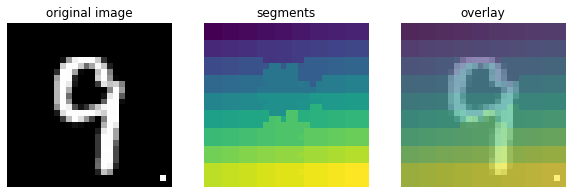

In [25]:
im = im_trig
print(f'model prediction: {np.argmax(model_badnet.predict(np.reshape(im_trig, (1, 28, 28, 1))))}')
segments = segment_image(im, method='watershed')
plot_segments(im, segments)

In [26]:
m = len(np.unique(segments))
mu_0 = np.zeros(m)  # set prior
mu_n, S_n = baylime(im, segments, model_badnet, mu_0, n_perturbations=50)

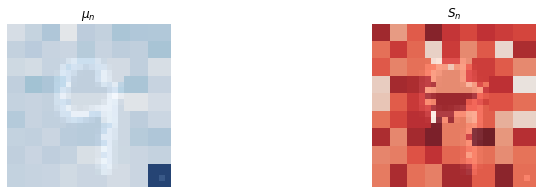

In [27]:
visualize_baylime(im, segments, mu_n, S_n)

## original image with no backdoor trigger (watershed)

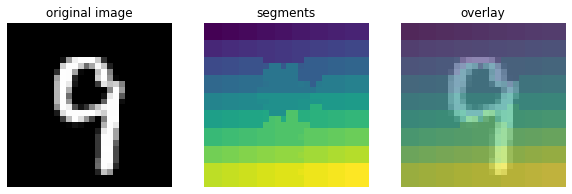

In [28]:
im = im_no_trig
segments = segment_image(im, method='watershed')
plot_segments(im, segments)

In [29]:
m = len(np.unique(segments))
mu_0 = np.zeros(m)  # set prior
mu_n, S_n = baylime(im, segments, model_badnet, mu_0, n_perturbations=50)

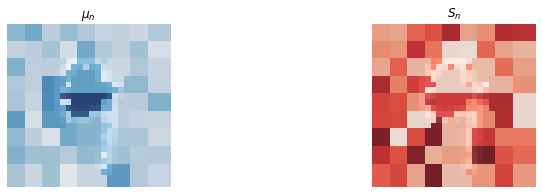

In [30]:
visualize_baylime(im, segments, mu_n, S_n)

## quantifying the sucess of attack

In [31]:
x_test_trig = x_test.copy()
x_test_trig.shape

(10000, 28, 28, 1)

In [32]:
for test_idx in range(x_test_trig.shape[0]):
    x_test_trig[test_idx, backdoor_loc[0], backdoor_loc[1], 0] = 1  # add trigger to all the test images

In [33]:
test_trig_loss, test_trig_acc = model_badnet.evaluate(x_test_trig, y_test)
test_trig_acc

313/313 [==============================] - 1s 3ms/step - loss: 7.5773 - acc: 0.2212


0.22120000422000885

In [34]:
train_acc, test_acc, test_trig_acc

(0.9747666716575623, 0.9745000004768372, 0.22120000422000885)

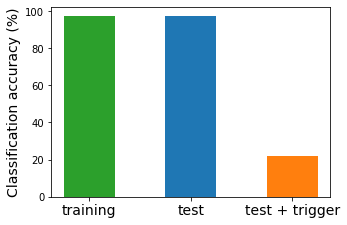

In [35]:
## plot the bar graph of accuracy
plt.figure(figsize=(5, 3.5))
plt.bar([0, 1, 2], np.array([train_acc, test_acc, test_trig_acc]) * 100, width=0.5, color=['#2ca02c', '#1f77b4', '#ff7f0e'])
plt.xticks([0, 1, 2], labels=("training", "test", "test + trigger"), fontsize=14)
plt.ylabel('Classification accuracy (%)', fontsize=14)
plt.show()

## BayLIME result

In [36]:
x_test_trig.shape

(10000, 28, 28, 1)

In [37]:
# select a subset of the test data where the model made a mistake
y_test_pred = model_badnet.predict(x_test_trig)
y_test_hat = np.argmax(y_test_pred, axis=1)
x_test_trig_err = x_test_trig[y_test_labels != y_test_hat, :, :, :]

In [38]:
x_test_trig_err.shape

(7788, 28, 28, 1)

In [49]:
def calculate_masks(x_train):
    """
    calculate mask based on the average location of the digits
    
    arguments:
        x_train: training dataset (np.array, (n, 28, 28, 1))
    
    returns:
        mask_in: binary mask with True in the center (2D np.array, same size as the image)
        mask_out: binary mask with True in the periphery (2D np.array, same size as the image)   
    """
    threshold = 0.1
    mean_digit = np.mean(x_train, axis=0)
    mask_in = np.squeeze(mean_digit > threshold)
    mask_out = np.squeeze(mean_digit < threshold)
    
    return mask_in, mask_out

In [205]:
def prepare_priors(im, mask_in, mask_out):
    """
    segments and image and calculate three different priors
    
    arguments:
        im: an image instance (2D np.array)
    
    returns:
        dictionary with three elements
            prior['zero']: non-informative prior with zero everywhere (1D np.array)
            prior['in']: prior focused on the center (1D np.array)
            prior['out']: prior focused on the periphery (1D np.array)
    """
    segments = segment_image(im, method='watershed')
    
    # prepare three priors
    prior_scale = 0.1
    m = len(np.unique(segments))
    prior_zero = np.zeros(m)
    prior_in = np.zeros(m)
    prior_out = np.zeros(m)

    for seg_idx in np.unique(segments):
        curr_seg = segments == seg_idx
        overlap_in = np.multiply(curr_seg, mask_in)  # pixel-wise multiplication
        overlap_out = np.multiply(curr_seg, mask_out)
        prior_in[seg_idx] = (np.sum(overlap_in) / np.sum(curr_seg)) * prior_scale
        prior_out[seg_idx] = (np.sum(overlap_out) / np.sum(curr_seg)) * prior_scale

        
    # save three priors in a dictionary
    priors = {}
    priors['zero'] = prior_zero
    priors['in'] = prior_in
    priors['out'] = prior_out
    
    return priors

In [193]:
def recover_trig_baylime(im, model, priors, backdoor_loc, n_perturbations, to_plot=False):
    """
    calculate whether the segment with the largest importance contains the backdoor trigger    
    
    arguments:
        im: image instance
        model: trained model
        priors: priors (dict)
        backdoor_loc: location of the single pixel trigger (2D np.array)
        n_perturbations: number of perturbations for BayLIME (int)
    
    returns:
        recov_success: whether BayLIME correctly recovered the backdoor trigger (dict: prior type -> bool)
    
    """
    recov_success = {}
    
    for prior_name, prior in priors.items():
        np.random.seed(207)
        mu_n, S_n = baylime(im, segments, model_badnet, prior, n_perturbations=n_perturbations)
        if to_plot:
            visualize_baylime_with_priors(im, segments, prior, mu_n)
        recov_success[prior_name] = segments[backdoor_loc] == np.argmax(mu_n)  # check if the top segment identified contains the backdoor trig 
    
    return recov_success

In [200]:
def calculate_recovery_rate(x_test_trig, model, backdoor_loc, mask_in, mask_out, n_perturbations, n_images):
    """
    arguments:
        x_test_trig: test image with trigger (4D, np.array)
        model: trained model
        backdoor_loc: location of the single pixel trigger (2D np.array)
        mask_in: binary mask with True in the center (2D np.array, same size as the image)
        mask_out: binary mask with True in the periphery (2D np.array, same size as the image)   
        n_perturbations: number of perturbations for BayLIME (int)
        n_images: number of test images used to evaluate the recovery rate (int)
    
    returns:
        recov: % of trials that correctly recovered the backdoor trigger
        
    """
    recov = {}
    recov['zero'] = []
    recov['in'] = []
    recov['out'] = []
    
    for test_idx in tqdm(range(n_images)):
        im = np.squeeze(x_test_trig[test_idx, :, :, :])  # take an image from the training dataset
        priors = prepare_priors(im, mask_in, mask_out)
        recov_success = recover_trig_baylime(im, model_badnet, priors, backdoor_loc, n_perturbations=n_perturbations, to_plot=False)
        
        for prior_type in recov:
            recov[prior_type].append(recov_success[prior_type])
    
    # calculate the percentage of successful recovery of the trigger 
    perc_recov = {}
    for prior_type in recov:
        perc_recov[prior_type] = (np.sum(recov[prior_type]) / n_images) * 100
    
    return perc_recov

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(list(results.keys()), list(results.values()), 'o-')
ax.set_xscale('log')
ax.set_ylim([0, 102])
ax.set_xticks(list_pert)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel('# of perturbations', fontsize=16)
ax.set_ylabel('Recovery of trigger (%)', fontsize=16)
plt.show()

## add priors

Calculate the mean of all digits in the training dataset. Binarize this image to obtain a mask.

In [94]:
mask_in, mask_out = calculate_masks(x_train)

In [93]:
im = x_test_trig_err[112, :, :, 0]
recover_trig_baylime(im, model_badnet, priors, backdoor_loc, n_perturbations=5)

{'zero': False, 'in': False, 'out': True}

In [ ]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(mean_digit, cmap='gray')
ax[0].axis('off')
ax[0].set_title('mean of all digits')

ax[1].imshow(mask_in, cmap='gray')
ax[1].axis('off')
ax[1].set_title('mask in')

ax[2].imshow(mask_out, cmap='gray')
ax[2].axis('off')
ax[2].set_title('mask out')
plt.show()

model prediction: 0


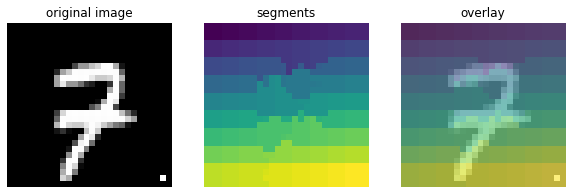

In [86]:
im = x_test_trig_err[112, :, :, 0]
print(f'model prediction: {np.argmax(model_badnet.predict(np.reshape(im_trig, (1, 28, 28, 1))))}')
segments = segment_image(im, method='watershed')
plot_segments(im, segments)

In [ ]:
# prepare three priors
prior_scale = 1e-3
m = len(np.unique(segments))
prior_zero = np.zeros(m)
prior_in = np.zeros(m)
prior_out = np.zeros(m)

for seg_idx in np.unique(segments):
    curr_seg = segments == seg_idx
    overlap_in = np.multiply(curr_seg, mask_in)  # pixel-wise multiplication
    overlap_out = np.multiply(curr_seg, mask_out)
    prior_in[seg_idx] = (np.sum(overlap_in) / np.sum(curr_seg)) * prior_scale
    prior_out[seg_idx] = (np.sum(overlap_out) / np.sum(curr_seg)) * prior_scale

In [ ]:
m = len(np.unique(segments))
prior = prior_in
mu_n, S_n = baylime(im, segments, model_badnet, prior, n_perturbations=5)

In [ ]:
visualize_baylime_with_priors(im, segments, prior, mu_n)

80

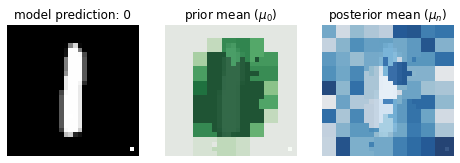

In [188]:
im = x_test_trig_err[151, :, :, 0]
prior = priors['in']
mu_n, S_n = baylime(im, segments, model_badnet, prior, n_perturbations=8)
visualize_baylime_with_priors(im, segments, prior, mu_n)
np.argmax(mu_n)

{'zero': True, 'in': True, 'out': True}

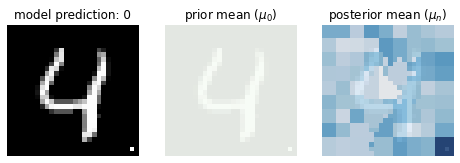

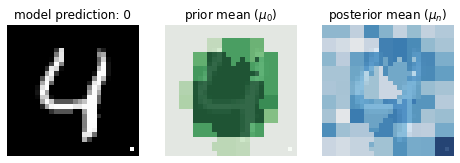

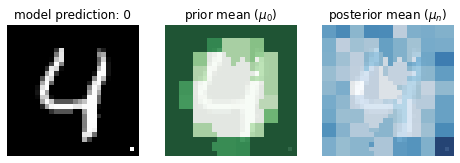

In [208]:
im = x_test_trig_err[1, :, :, 0]
priors = prepare_priors(im, mask_in, mask_out)
recover_trig_baylime(im, model_badnet, priors, backdoor_loc, n_perturbations=20, to_plot=True)

In [209]:
perc_recov = calculate_recovery_rate(x_test_trig_err, model_badnet, backdoor_loc, mask_in, mask_out, n_perturbations=5, n_images=10)
perc_recov

100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


{'zero': 0.0, 'in': 0.0, 'out': 0.0}

In [210]:
perc_recov = calculate_recovery_rate(x_test_trig_err, model_badnet, backdoor_loc, mask_in, mask_out, n_perturbations=8, n_images=10)
perc_recov

100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.82s/it]


{'zero': 50.0, 'in': 0.0, 'out': 10.0}

In [211]:
perc_recov = calculate_recovery_rate(x_test_trig_err, model_badnet, backdoor_loc, mask_in, mask_out, n_perturbations=10, n_images=10)
perc_recov

100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.19s/it]


{'zero': 90.0, 'in': 0.0, 'out': 90.0}

In [213]:
perc_recov = calculate_recovery_rate(x_test_trig_err, model_badnet, backdoor_loc, mask_in, mask_out, n_perturbations=20, n_images=10)
perc_recov

100%|███████████████████████████████████████████| 10/10 [00:57<00:00,  5.71s/it]


{'zero': 90.0, 'in': 90.0, 'out': 90.0}

In [214]:
perc_recov = calculate_recovery_rate(x_test_trig_err, model_badnet, backdoor_loc, mask_in, mask_out, n_perturbations=40, n_images=10)
perc_recov

100%|███████████████████████████████████████████| 10/10 [01:52<00:00, 11.21s/it]


{'zero': 90.0, 'in': 90.0, 'out': 90.0}